# Running from R

![dandelion_logo](img/dandelion_logo_illustration.png)

## Foreword
***dandelion*** is written in `python==3.7.6` and it is primarily a single-cell BCR-seq analysis package. It makes use of some tools from the fantastic [*immcantation suite*](https://immcantation.readthedocs.io/) and the main idea is that it implements a workflow for the pre-processing and exploratory stages with integrated use of tools from *immcantation* for the BCR side of things and analysis tools from [*scanpy*](https://scanpy.readthedocs.io/) for the RNA-seq side of things. I hope to be able to introduce some new single-cell BCR-seq exploratory tools down the road through *dandelion*. 

***dandelion*** can be run in `R` through `reticulate`. This notebook will try to replicate the examples in notebooks 1-3 entirely in R. 

There are some issues with the conversion of dataframes between python and R so I would ***not*** recommend saving the final `AnnData` object as a final out file, but only use this to help generate the intermediate files from the BCR processing and the plots. Please store your original analysis some where safe. I would also skip quantify mutation step due to conflicts between rpy2 and reticulate.

For more details, please refer to the original python notebooks.

Let's start!

First, install reticulate via if you don't already have it:

```R
install.packages('reticulate')
```

Because we are managing the packages through a conda virtual environment, we will need to point reticulate to the right python paths.

Currently, rpy2>=3.4 or >=3.3.2,<3.3.5 works.

In [1]:
library(reticulate)
use_condaenv('dandelion')
# or use Sys.setenv(RETICULATE_PYTHON = conda_python(envname='dandelion'))

You can check if the python config is set up properly with `py_config()`

In [2]:
py_config()

python:         /Users/kt16/miniconda3/envs/dandelion/bin/python
libpython:      /Users/kt16/miniconda3/envs/dandelion/lib/libpython3.7m.dylib
pythonhome:     /Users/kt16/miniconda3/envs/dandelion:/Users/kt16/miniconda3/envs/dandelion
version:        3.7.8 | packaged by conda-forge | (default, Nov 17 2020, 23:22:07)  [Clang 10.0.1 ]
numpy:          /Users/kt16/miniconda3/envs/dandelion/lib/python3.7/site-packages/numpy
numpy_version:  1.19.4

NOTE: Python version was forced by RETICULATE_PYTHON

To proceed with the analyses, we first change the working directory and also import the dandelion module.

In [3]:
# change directory to somewhere more workable
setwd('/Users/kt16/Downloads/dandelion_tutorial_R/')
ddl = import('dandelion')

As per reticulate convention, python `.` operators are to be swaped with `$` in R.

## Pre-processing
To being the BCR preprocessing, the minimum files you require are the following:
```console
filtered_contig.fasta
filtered_contig_annotations.csv
```

### Step 1: Formatting the headers of the cellranger fasta file
This will do the following:
1) add the prefix provided to every sequence header

2) add the prefix provided to every contig_id in the annotation.csv file

3) create a folder called `dandelion/data` (if left as default) and saves a copy of these files in that directory.

In [4]:
# the first option is a list of fasta files to format and the second option is the list of prefix to add to each file.
samples = c('sc5p_v2_hs_PBMC_1k', 'sc5p_v2_hs_PBMC_10k', 'vdj_v1_hs_pbmc3', 'vdj_nextgem_hs_pbmc3')
ddl$pp$format_fastas(samples, prefix = samples)

### Step 2: Reannotate the V/D/J genes with *igblastn*.

`ddl$pp$reannotate_genes` uses [*changeo*](https://changeo.readthedocs.io/en/stable/examples/10x.html)'s scripts to call *igblastn* to reannotate the fasta files. Depending on the `fileformat` option, it will parse out as either an `airr` (default) or `changeo`-legacy TSV file. Importantly, with the recent update to changeo v1.0.0, all the column headers, including *changeo* format, are now adhereing to the [*AIRR*](http://docs.airr-community.org/) standard (lowercase and some column name changes). Specifying `extended = True` will return the additional 10x annotation of V/D/J genes but they are unnecessary at this stage.

In [5]:
ddl$pp$reannotate_genes(samples)

you should see something like this in the terminal:
```console
Assigning genes :   0%|                                        | 0/4 [00:00<?, ?it/s]   
START> AssignGenes
 COMMAND> igblast
 VERSION> 1.15.0
    FILE> sc5p_v2_hs_PBMC_10k_b_filtered_contig.fasta
ORGANISM> human
    LOCI> ig
   NPROC> 4

PROGRESS> 12:30:37 |Running IgBLAST          | 0.0 min

```

### Step 3 : Reassigning heavy chain V gene alleles *(optional but recommended)*

Next, we use *immcantation's TIgGER* method to reassign allelic calls for heavy chain V genes with `pp.reassign_alleles`. As stated in TIgGER's [website](https://tigger.readthedocs.io/en/stable/) and [manuscript](https://pubmed.ncbi.nlm.nih.gov/25675496/), *'TIgGER is a computational method that significantly improves V(D)J allele assignments by first determining the complete set of gene segments carried by an individual (including novel alleles) from V(D)J-rearrange sequences. TIgGER can then infer a subject’s genotype from these sequences, and use this genotype to correct the initial V(D)J allele assignments.'*

This impact's on how contigs are chosen for finding clones later so it is highly recommended to run it. It is also important when considering to do mutational analysis. 

However, the main caveat is that this needs to be run on multiple samples from the same subject to allow for more information to be used to confidently assign a genotyped *v_call*. In this tutorial, I'm assuming the four samples can be split into two sets where sets of two corresponds to a different/single individual. So while important, this step can be skipped if you don't have the samples to do this. 

`pp.reassign_alleles` requires the `combined_folder` option to be specified so that a merged/concatenated file can be produced for running TIgGER. The function also runs `pp.create_germlines` using the germline database updated with the germline corrections from TIgGER. The default behavior is that it will return a `germline_alignment_d_mask` column in the final output. This can be changed by specifying `germ_types` option; see [here](https://changeo.readthedocs.io/en/stable/tools/CreateGermlines.html#creategermlines) for other options.

Specifying `fileformat = 'changeo'` will run on changeo formatted files if this was run earlier; but it's probably best to stick to airr's standard format.

In [6]:
# reassigning alleles on the first set of samples
ddl$pp$reassign_alleles(samples[1:2], combined_folder = 'tutorial_scgp1')

In [7]:
# reassigning alleles on the first set of samples
ddl$pp$reassign_alleles(samples[3:4], combined_folder = 'tutorial_scgp2')

We can see that most of the original ambiguous V calls have now been corrected and only a few remain. These will be flagged as multi later on and can probably be excluded from detailed analyses. For now, leaving them in the data will not impact on subsequent analyses. 

### Step 4: Assigning constant region calls

10X's annotation.csv files provides a *c_gene* column, but rather than simply relying on 10x's annotation, [hk6](https://twitter.com/hamish_king) recommended using [*immcantation-presto*'s *MaskPrimers.py*](https://presto.readthedocs.io/en/version-0.5.3---license-change/tools/MaskPrimers.html) with his custom primer list and I tested that; worked well but it took ***20 min*** for the first file (~6k contigs). It also only calls the constant region for the heavy chains. The processing speed for MaskPrimers can be sped up with using the filtered file.

Anyway, as an alternative, I wrote a pre-processing function, `ddl$pp$assign_isotypes`, to use *blast* to annotate constant region calls for all contigs and retrieves the call, merging it with the tsv files. This function will simply overwrite the output from previous steps and add a *c_call* column at the end, or replace the existing column if it already exists.

To deal with incorrect constant gene calls due to insufficient length, an internal subfunction will run a pairwise alignment against [hk6](https://twitter.com/hamish_king)'s curated sequences that were deemed to be highly specific in distinguishing IGHA1-2, IGHG1-4. I have also curated sets of sequences that should help deal with `IGLC3/6/7` as these are problematic too. If there's insufficient info, the `c_call` will be returned as a combination of the most aligned sets of sequences. Because of how similar the light chains are, extremely ambiguous calls (only able to map to a common sequence across the light chains) will be returned as `IGLC`. This typically occurs when the constant sequence is very short. Those that have equal alignment scores between `IGLC3/6/7` sequences and the common sequence will be returned as a concatenated call; for example with a contig initially annotated as `IGLC3` will be returned as `IGLC,IGLC3`. If you do not want this subfunction to run, toggle:

```R
correct_c_call = FALSE
```

==========================

Before running, there is a need to set up a database with IMGT constant gene fasta sequences using *makeblastdb*,
basically following the instructions from https://www.ncbi.nlm.nih.gov/books/NBK279688/. ***This only needs to be done once.***

The fasta files were downloaded from IMGT and only sequences corresponding to *CH1* region for each constant gene/allele were retained. The headers were trimmed to only keep the gene and allele information. Links to find the sequences can be found here : [***human***](http://www.imgt.org/genedb/GENElect?query=7.2+IGHC&species=Homo+sapiens) and [***mouse***](http://www.imgt.org/genedb/GENElect?query=7.2+IGHC&species=Mus).

The database file is provided in the repository and I've written a utility function `ddl$utl$makeblastdb` to prep new fasta files/databases if you need to.
```R
ddl$utl$makeblastdb('/path/to/folder/containing/database/blast/human/human_BCR_C.fasta')
```

**Again, we really only need to do it once**; the file path can be added as an environmental variable after running:
```bash
echo "export BLASTDB=/path/to/folder/containing/database/blast/" >> ~/.bash_profile
source ~/.bash_profile
```

I've set it up so that if the default option for `blastdb` is left as `None`, the function will retrieve a relative path from the environmental variable `$BLASTDB` and then, depending on which organism was specified (default = human), point to the correct fasta file. If you choose not to add it to environment, you can provide a string specifying a path to the fasta file for the `blastdb` option. The string has to point directly to the fasta file, i.e. end with `.fasta`.

==========================

In [8]:
# ddl$utl$makeblastdb('/Users/kt16/Documents/Github/dandelion/database/blast/human/human_BCR_C.fasta')

In [9]:
ddl$pp$assign_isotypes(samples)

This still takes a while when dealing with large files; the number of cpus to size of file isn't exactly linear. Nevertheless, I have enabled parallelization as default because there were noticeable improvements in processing speeds with the smaller files. Maybe it will work better on a cluster with more cpus, rather than just a standard laptop. Other than a couple of samples that took about ***~10-40min***, most ran within ***2-5min***. I expect that this should run faster with filtered files too. 

The default option will return a summary plot that can be disabled with `plot = FALSE`. In R, if you leave the `plot = TRUE`, it will wait for you to close the plots before continuing.

Also, the function can be run with `fileformat = 'changeo'` if preferred.

It's worthwhile to manually check the the sequences for constant calls returned as IGHA1-2, IGHG1-4 and the light chains and manually correct them if necessary.

### Step 5: Quantify mutations *(optional)*.

In my original notebook, at this stage, I quantified the basic mutational load with `ddl.pp.quantify_mutations` before subsequent analyses. This would not run properly within this R session due to rpy2/reticulate conflict. Instead, i'd recommend you to run this separately on the. `*_igblast_gap_genotyped.tsv` file that was generated in the previous step, by following [Shazam's tutorial](https://shazam.readthedocs.io/en/stable/vignettes/Mutation-Vignette/) on basic mutational analysis, before continuing to step 6.

## Filtering

**Create a Seurat object from the transcriptome data**

Let's first import the gene expression data. Let's try from Seurat object.

In [10]:
library(Seurat)
samples = c('sc5p_v2_hs_PBMC_1k', 'sc5p_v2_hs_PBMC_10k', 'vdj_v1_hs_pbmc3', 'vdj_nextgem_hs_pbmc3')
seurat_objects = list()
for (i in 1:length(samples)){
    filename = paste0(samples[i], '/', samples[i], "_filtered_feature_bc_matrix.h5")
    data <- Read10X_h5(filename)
    seurat_objects[[i]] <- CreateSeuratObject(counts = data$`Gene Expression`)
}

Genome matrix has multiple modalities, returning a list of matrices for this genome

Genome matrix has multiple modalities, returning a list of matrices for this genome

Genome matrix has multiple modalities, returning a list of matrices for this genome

Genome matrix has multiple modalities, returning a list of matrices for this genome



In [11]:
# merge them, there's probably better ways
merged1 = merge(seurat_objects[[1]], seurat_objects[[2]], add.cell.ids = samples[1:2])
merged2 = merge(seurat_objects[[3]], seurat_objects[[4]], add.cell.ids = samples[3:4])
merged = merge(merged1, merged2)

In [12]:
head(merged@meta.data)

,orig.ident,nCount_RNA,nFeature_RNA
,<chr>,<dbl>,<int>
sc5p_v2_hs_PBMC_1k_AAACCTGCAGCCTGTG-1,SeuratProject,5029,1819
sc5p_v2_hs_PBMC_1k_AAACGGGTCGCTGATA-1,SeuratProject,4343,1738
sc5p_v2_hs_PBMC_1k_AAAGATGTCCTCGCAT-1,SeuratProject,898,554
sc5p_v2_hs_PBMC_1k_AAAGCAAAGTATGACA-1,SeuratProject,4999,1796
sc5p_v2_hs_PBMC_1k_AAAGCAATCCATTCTA-1,SeuratProject,601,416
sc5p_v2_hs_PBMC_1k_AAATGCCCACTTAAGC-1,SeuratProject,4998,1530


`dandelion` removes hyphen from the cell barcodes as a default behaviour, so we will do the same for the `Seurat` object.

In [13]:
# remove the -# from the end of each cell name
merged <- RenameCells(merged, new.names = gsub('-.*', '', row.names(merged@meta.data)))
merged

An object of class Seurat 
38224 features across 30471 samples within 1 assay 
Active assay: RNA (38224 features, 0 variable features)

**Standard Seurat pre-processing workflow**

In [14]:
merged[["percent.mt"]] <- PercentageFeatureSet(merged, pattern = "^MT-")
merged <- subset(merged, subset = nFeature_RNA > 200 & nFeature_RNA < 2500 & percent.mt < 5)
merged <- NormalizeData(merged)
merged <- FindVariableFeatures(merged, selection.method = "vst", nfeatures = 2000)
merged <- ScaleData(merged)
merged <- RunPCA(merged, features = VariableFeatures(object = merged))
merged <- FindNeighbors(merged, dims = 1:50)
merged <- FindClusters(merged)
merged <- RunUMAP(merged, dims = 1:50)

Centering and scaling data matrix

PC_ 1 
Positive:  LYZ, S100A9, FCN1, S100A8, CST3, VCAN, MNDA, IFI30, SPI1, SERPINA1 
	   S100A12, CSTA, TYMP, CTSS, CD14, LST1, CYBB, FTL, MS4A6A, CSF3R 
	   TYROBP, CD68, TNFAIP2, CFD, NCF2, CD36, CEBPD, AIF1, GRN, LILRB2 
Negative:  IFITM1, RPS27, IL32, LTB, RPS12, RPS18, IL7R, TCF7, CD7, TRBC2 
	   NOSIP, RPS29, LEF1, LINC00861, ETS1, CD247, CCR7, LIME1, CD2, MAL 
	   SELL, GZMM, TRBC1, AQP3, OXNAD1, AES, CD69, ARL4C, PIM2, TRAC 
PC_ 2 
Positive:  MS4A1, CD79A, BANK1, LINC00926, IGHM, HLA-DQA1, FCER2, HLA-DQB1, TCL1A, CD79B 
	   FCRLA, CD19, VPREB3, RALGPS2, CD22, HLA-DRA, FCRL1, HLA-DOB, AFF3, NIBAN3 
	   IGHD, POU2AF1, BLNK, BLK, HLA-DPB1, SPIB, IGKC, ADAM28, CD24, HVCN1 
Negative:  NKG7, HCST, CST7, PRF1, GZMA, GNLY, CTSW, KLRD1, IFITM1, FGFBP2 
	   FCGR3A, KLRF1, SPON2, S100A4, HOPX, GZMB, SRGN, IFITM2, CCL5, CLIC3 
	   CD7, MATK, ITGB2, TBX21, IL2RB, CD247, KLRB1, GZMM, SH2D1B, S1PR5 
PC_ 3 
Positive:  NKG7, GNLY, GZMB, CST7, PRF1, KLRD1, GZM

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 18634
Number of edges: 807300

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9222
Number of communities: 24
Elapsed time: 2 seconds


Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
19:22:49 UMAP embedding parameters a = 0.9922 b = 1.112

19:22:49 Read 18634 rows and found 50 numeric columns

19:22:49 Using Annoy for neighbor search, n_neighbors = 30

19:22:49 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

19:22:52 Writing NN index file to temp file /var/folders/nb/wrd6px6171j52lqpmkljt6vw000l2l/T//Rtmp467IqC/file92ce5a22d886

19:22:52 Searching Annoy index using 1 thread, search_k = 3000

19:22:59 Annoy recall = 100%

19:22:59 Commencing smooth kNN distance calibra

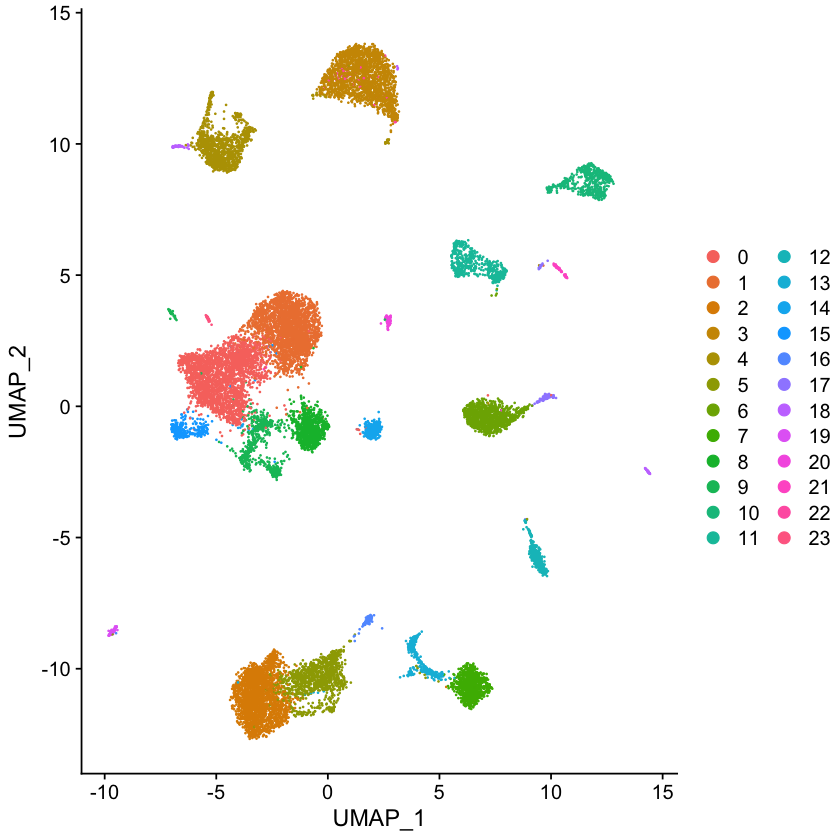

In [15]:
DimPlot(merged, reduction = "umap")

In [16]:
merged

An object of class Seurat 
38224 features across 18634 samples within 1 assay 
Active assay: RNA (38224 features, 2000 variable features)
 2 dimensional reductions calculated: pca, umap

In order for `dandelion` to do the next step (marking/filtering of poor quality BCRs and BCR doublets), we need to include a column in the metadata, `filter_rna`. This column will tell `dandelion` whether or not the cell has passed transcriptomic QCs. So, we will set the column to `FALSE` i.e. every cell passed QC. This is important because we want to remove as many doublets and poor quality contigs to save time on computation and construction of the final data tables.

In [17]:
# create a column called filter_rna and set it to FALSE
merged@meta.data$filter_rna = FALSE

**Convert to AnnData**

We will need to convert the `Seurat` object to `AnnData` to be able to continue.
`AnnData` `.obs` slot is essentially the same as `@meta.data` in seurat.

In [18]:
sc = import("scanpy")
# convert the meta.data slot to a python friendly object
obs = r_to_py(merged@meta.data)
normcounts = r_to_py(Matrix::t(GetAssayData(merged)))

In [19]:
adata = sc$AnnData(X = normcounts, obs = obs)
adata

AnnData object with n_obs × n_vars = 18634 × 38224
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.0.8', 'seurat_clusters', 'filter_rna'

We need to populate the `.neighbors` slots via scanpy for smooth transfer later.

In [20]:
sc$pp$neighbors(adata)
adata

AnnData object with n_obs × n_vars = 18634 × 38224
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.0.8', 'seurat_clusters', 'filter_rna'
    uns: 'neighbors'
    obsm: 'X_pca'
    obsp: 'distances', 'connectivities'

**Read in the BCR files and merge them**

In [21]:
files = list()
for (i in 1:length(samples)){
    filename = paste0(samples[i], '/dandelion/data/', samples[i], "_b_filtered_contig_igblast_gap_genotyped.tsv")
    files[[i]] <- readr::read_tsv(filename)
}
combined_bcr = do.call(rbind, files)
head(combined_bcr)

Registered S3 method overwritten by 'cli':
  method     from    
  print.boxx spatstat

── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  sequence_id = col_character(),
  sequence = col_character(),
  rev_comp = col_logical(),
  productive = col_logical(),
  v_call = col_character(),
  d_call = col_character(),
  j_call = col_character(),
  sequence_alignment = col_character(),
  germline_alignment = col_character(),
  junction = col_character(),
  junction_aa = col_character(),
  v_cigar = col_character(),
  d_cigar = col_character(),
  j_cigar = col_character(),
  locus = col_character(),
  stop_codon = col_logical(),
  vj_in_frame = col_logical(),
  sequence_alignment_aa = col_character(),
  germline_alignment_aa = col_character(),
  v_sequence_alignment = col_character()
  # ... with 36 more columns
)
ℹ Use `spec()` for the full column specifications.


sequence_id,sequence,rev_comp,productive,v_call,d_call,j_call,sequence_alignment,germline_alignment,junction,⋯,c_sequence_alignment,c_germline_alignment,c_sequence_start,c_sequence_end,c_score,c_identity,c_support,sample_id,v_call_genotyped,germline_alignment_d_mask
<chr>,<chr>,<lgl>,<lgl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
sc5p_v2_hs_PBMC_1k_AACTCCCAGGCTAGGT-1_contig_1,ACTGCGGGGGTAAGAGGTTGTGTCCACCATGGCCTGGACTCCTCTCCTCCTCCTGTTCCTCTCTCACTGCACAGGTTCCCTCTCGCAGGCTGTGCTGACTCAGCCGTCTTCCCTCTCTGCATCTCCTGGAGCATCAGCCAGTCTCACCTGCACCTTGCGCAGTGGCATCAATGTTGGTACCTACAGGATATACTGGTACCAGCAGAAGCCAGGGAGTCCTCCCCAGTATCTCCTGAGGTACAAATCAGACTCAGATAAGCAGCAGGGCTCTGGAGTCCCCAGCCGCTTCTCTGGATCCAAAGATGCTTCGGCCAATGCAGGGATTTTACTCATCTCTGGGCTCCAGTCTGAGGATGAGGCTGACTATTACTGTATGATTTGGCACAGCAGCGCTTGGGTGTTCGGCGGAGGGACCAAGCTGACCGTCCTAGGTCAGCCCAAGGCTGCCCCCTCGGTCACTCTGTTCCCGCCCTCCTCTGAGGAGCTTCAAGCCAACAAGGCCACACTGGTGTGTCTCATAAGTGACTTCTACCCGGGAGCCGTGACAGTGGCCTGGAAGGCAGATAGCAGCCCCGTCAAGGCGGGAGTGGAGACCACCACACCCTCCAAACAAAGCAACAACAAGTACGCGGCCAGCAGCTA,FALSE,TRUE,IGLV5-45*03,NA,IGLJ3*02,CAGGCTGTGCTGACTCAGCCGTCTTCC...CTCTCTGCATCTCCTGGAGCATCAGCCAGTCTCACCTGCACCTTGCGCAGTGGCATCAATGTT.........GGTACCTACAGGATATACTGGTACCAGCAGAAGCCAGGGAGTCCTCCCCAGTATCTCCTGAGGTACAAATCAGAC.........TCAGATAAGCAGCAGGGCTCTGGAGTCCCC...AGCCGCTTCTCTGGATCCAAAGATGCTTCGGCCAATGCAGGGATTTTACTCATCTCTGGGCTCCAGTCTGAGGATGAGGCTGACTATTACTGTATGATTTGGCACAGCAGCGCTTGGGTGTTCGGCGGAGGGACCAAGCTGACCGTCCTAG,CAGGCTGTGCTGACTCAGCCGTCTTCC...CTCTCTGCATCTCCTGGAGCATCAGCCAGTCTCACCTGCACCTTGCGCAGTGGCATCAATGTT.........GGTACCTACAGGATATACTGGTACCAGCAGAAGCCAGGGAGTCCTCCCCAGTATCTCCTGAGGTACAAATCAGAC.........TCAGATAAGCAGCAGGGCTCTGGAGTCCCC...AGCCGCTTCTCTGGATCCAAAGATGCTTCGGCCAATGCAGGGATTTTACTCATCTCTGGGCTCCAGTCTGAGGATGAGGCTGACTATTACTGGGTGTTCGGCGGAGGGACCAAGCTGACCGTCCTAG,TGTATGATTTGGCACAGCAGCGCTTGGGTGTTC,⋯,GGTCAGCCCAAGGCTGCCCCCTCGGTCACTCTGTTCCCGCCCTCCTCTGAGGAGCTTCAAGCCAACAAGGCCACACTGGTGTGTCTCATAAGTGACTTCTACCCGGGAGCCGTGACAGTGGCCTGGAAGGCAGATAGCAGCCCCGTCAAGGCGGGAGTGGAGACCACCACACCCTCCAAACAAAGCAACAACAAGTACGCGGCCAGCAGCTA,GGTCAGCCCAAGGCTGCCCCCTCGGTCACTCTGTTCCCGCCCTCCTCTGAGGAGCTTCAAGCCAACAAGGCCACACTGGTGTGTCTCATAAGTGACTTCTACCCGGGAGCCGTGACAGTGGCCTGGAAGGCAGATAGCAGCCCCGTCAAGGCGGGAGTGGAGACCACCACACCCTCCAAACAAAGCAACAACAAGTACGCGGCCAGCAGCTA,431,642,392.610,100,1e-111,sc5p_v2_hs_PBMC_1k,IGLV5-45*03,CAGGCTGTGCTGACTCAGCCGTCTTCC...CTCTCTGCATCTCCTGGAGCATCAGCCAGTCTCACCTGCACCTTGCGCAGTGGCATCAATGTT.........GGTACCTACAGGATATACTGGTACCAGCAGAAGCCAGGGAGTCCTCCCCAGTATCTCCTGAGGTACAAATCAGAC.........TCAGATAAGCAGCAGGGCTCTGGAGTCCCC...AGCCGCTTCTCTGGATCCAAAGATGCTTCGGCCAATGCAGGGATTTTACTCATCTCTGGGCTCCAGTCTGAGGATGAGGCTGACTATTACTGTATGATTTGGCACAGCAGCGCTTGGGTGTTCGGCGGAGGGACCAAGCTGACCGTCCTAG
sc5p_v2_hs_PBMC_1k_AACTCCCAGGCTAGGT-1_contig_2,ATACTTTCTGAGAGTCCTGGACCTCCTGTGCAAGAACATGAAACATCTGTGGTTCTTCCTCCTCCTGGTGGCAGCTCCCAGATGGGTCCTGTCCCAGGTGCAGCTGCAGGAGTCGGGCCCAGGACTGGTGAAGCCTTCACAGACCCTGTCCCTCACCTGCACTGTCTCTGGTGGCTCCATCAGCAGTGGTAGTTACTACTGGAGCTGGATCCGGCAGCCCGCCGGGAAGGGACTGGAGTGGATTGGGCGTATCTATACCAGTGGGAGCACCAACTACAACCCCTCCCTCAAGAGTCGAGTCACCATATCAGTAGACACGTCCAAGAACCAGTTCTCCCTGAAGCTGAGCTCTGTGACCGCCGCAGACACGGCCGTGTATTACTGTGCGAGAGAAAATTACGATTTTTGGAGTGGTTATTACCACGGTGCGGACGTCTGGGGCCAAGGGACCACGGTCACCGTCTCCTCAGGGAGTGCATCCGCCCCAACCCTTTTCCCCCTCGTCTCCTGTGAGAATTCCCCGTCGGATACGAGCAGCGTG,FALSE,TRUE,IGHV4-61*02,IGHD3-3*01,IGHJ6*02,CAGGTGCAGCTGCAGGAGTCGGGCCCA...GGACTGGTGAAGCCTTCACAGACCCTGTCCCTCACCTGCACTGTCTCTGGTGGCTCCATCAGC......AGTGGTAGTTACTACTGGAGCTGGATCCGGCAGCCCGCCGGGAAGGGACTGGAGTGGATTGGGCGTATCTATACCAGT.........GGGAGCACCAACTACAACCCCTCCCTCAAG...AGTCGAGTCACCATATCAGTAGACACGTCCAAGAACCAGTTCTCCCTGAAGCTGAGCTCTGTGACCGCCGCAGACACGGCCGTGTATTACTGTGCGAGAGAAAATTACGATTTTTGGAGTGGTTATTACCACGGTGCGGACGTCTGGGGCCAAGGGACCACGGTCACCGTCTCCTCA,CAGGTGCAGCTGCAGGAGTCGGGCCCA...GGACTGGTGAAGCCTTCACAGACCCTGTCCCTCACCTGCACTGTCTCTGGTGGCTCCATCAGC......AGTGGTAGTTACTACTGGAGCTGGATCCGGCAGCCCGCCGGGAAGGGACTGGAGTGGATTGGGCGTATCTATACCAGT.........GGGAGCACCAACTACAACCCCTCCCTCAAG...AGTCGAGTCACCATATCAGTAGACACGTC

### Run `ddl$pp$filter_bcr`

In [22]:
vdj_results_list = ddl$pp$filter_bcr(combined_bcr, adata)
vdj_results_list

[[1]]
Dandelion class object with n_obs = 971 and n_contigs = 1959
    data: 'sequence_id', 'sequence', 'rev_comp', 'productive', 'v_call', 'd_call', 'j_call', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'v_cigar', 'd_cigar', 'j_cigar', 'locus', 'stop_codon', 'vj_in_frame', 'sequence_alignment_aa', 'germline_alignment_aa', 'v_alignment_start', 'v_alignment_end', 'd_alignment_start', 'd_alignment_end', 'j_alignment_start', 'j_alignment_end', 'v_sequence_alignment', 'v_sequence_alignment_aa', 'v_germline_alignment', 'v_germline_alignment_aa', 'd_sequence_alignment', 'd_sequence_alignment_aa', 'd_germline_alignment', 'd_germline_alignment_aa', 'j_sequence_alignment', 'j_sequence_alignment_aa', 'j_germline_alignment', 'j_germline_alignment_aa', 'fwr1', 'fwr1_aa', 'cdr1', 'cdr1_aa', 'fwr2', 'fwr2_aa', 'cdr2', 'cdr2_aa', 'fwr3', 'fwr3_aa', 'fwr4', 'fwr4_aa', 'cdr3', 'cdr3_aa', 'junction_length', 'v_score', 'd_score', 'j_score', 'v_support', 'd_support', 'j_support'

This returns a two level list in R. The first level is the VDJ results, stored as a `Dandelion` python-class object and the second level is the accompanying `AnnData` object. 

The `Dandelion` class is structured like a multi-slot object and the two data frames below are linked:
1) data <- BCR table with row names as individual vdj contigs 

2) metadata <- BCR table collapsed to cell barcodes as row names

More details on the `Dandelion` class are in my python notebooks. The most important slot for now, is the `metadata` slot within `Dandelion`.

In order for the `metadata` to form properly, there must not be any duplicate barcodes, or incorrectly retrieved information from the `data` slot. If you end up with a `Dandelion` object that only contains the `data` slot filled, it means one of the two conditions happened. In those situations, I would recommend you to send me a copy of the file so I can check why it's failing; it is usually due to coding eror that arise from string and float incompatibilities when constructing the object.

To save the `Dandelion` object, you can do the following:

In [23]:
vdj_results_list[[1]]$write_pkl('vdj_save.pkl.pbz2')

The `.pkl.pbz2` extension is basically a bzip2-compressed pickle file format from python.

You can also save using `$write_h5`. 

In [24]:
vdj_results_list[[1]]$write_h5('vdj_save.h5')

To read the file back into R, you can do the following:

In [25]:
vdj_data <- ddl$read_pkl('vdj_save.pkl.pbz2')
vdj_data

Dandelion class object with n_obs = 971 and n_contigs = 1959
    data: 'sequence_id', 'sequence', 'rev_comp', 'productive', 'v_call', 'd_call', 'j_call', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'v_cigar', 'd_cigar', 'j_cigar', 'locus', 'stop_codon', 'vj_in_frame', 'sequence_alignment_aa', 'germline_alignment_aa', 'v_alignment_start', 'v_alignment_end', 'd_alignment_start', 'd_alignment_end', 'j_alignment_start', 'j_alignment_end', 'v_sequence_alignment', 'v_sequence_alignment_aa', 'v_germline_alignment', 'v_germline_alignment_aa', 'd_sequence_alignment', 'd_sequence_alignment_aa', 'd_germline_alignment', 'd_germline_alignment_aa', 'j_sequence_alignment', 'j_sequence_alignment_aa', 'j_germline_alignment', 'j_germline_alignment_aa', 'fwr1', 'fwr1_aa', 'cdr1', 'cdr1_aa', 'fwr2', 'fwr2_aa', 'cdr2', 'cdr2_aa', 'fwr3', 'fwr3_aa', 'fwr4', 'fwr4_aa', 'cdr3', 'cdr3_aa', 'junction_length', 'v_score', 'd_score', 'j_score', 'v_support', 'd_support', 'j_support', 'v_i

or

In [26]:
vdj_data2 <- ddl$read_h5('vdj_save.h5')
vdj_data2

Dandelion class object with n_obs = 971 and n_contigs = 1959
    data: 'sequence_id', 'sequence', 'rev_comp', 'productive', 'v_call', 'd_call', 'j_call', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'v_cigar', 'd_cigar', 'j_cigar', 'locus', 'stop_codon', 'vj_in_frame', 'sequence_alignment_aa', 'germline_alignment_aa', 'v_alignment_start', 'v_alignment_end', 'd_alignment_start', 'd_alignment_end', 'j_alignment_start', 'j_alignment_end', 'v_sequence_alignment', 'v_sequence_alignment_aa', 'v_germline_alignment', 'v_germline_alignment_aa', 'd_sequence_alignment', 'd_sequence_alignment_aa', 'd_germline_alignment', 'd_germline_alignment_aa', 'j_sequence_alignment', 'j_sequence_alignment_aa', 'j_germline_alignment', 'j_germline_alignment_aa', 'fwr1', 'fwr1_aa', 'cdr1', 'cdr1_aa', 'fwr2', 'fwr2_aa', 'cdr2', 'cdr2_aa', 'fwr3', 'fwr3_aa', 'fwr4', 'fwr4_aa', 'cdr3', 'cdr3_aa', 'junction_length', 'v_score', 'd_score', 'j_score', 'v_support', 'd_support', 'j_support', 'v_i

## Finding clones
`Dandelion` comes with a method to define clones based on V-J gene usuage and CDR3 junction similarity but you can always run Immcantation/Change-O's DefineClones with the filtered file from earlier using their [tutorial](https://changeo.readthedocs.io/en/stable/examples/10x.html). To use dandelion's you just need to do the following:

In [27]:
ddl$tl$find_clones(vdj_data)

## Calculating size of clones

Sometimes it's useful to evaluate the size of the clone. Here `ddl$tl$clone_size` does a simple calculation to enable that.

In [28]:
ddl$tl$clone_size(vdj_data)

You can also specify `max_size` to clip off the calculation at a fixed value.

In [29]:
ddl$tl$clone_size(vdj_data, max_size = 3)

I have blitz through the last 3 functions without showing you the output but don't worry, they are all stashed in the `Dandelion` object.

In [30]:
# compare the column names in the metadata slot of the object below with the one above.
vdj_data

Dandelion class object with n_obs = 971 and n_contigs = 1959
    data: 'sequence_id', 'sequence', 'rev_comp', 'productive', 'v_call', 'd_call', 'j_call', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'v_cigar', 'd_cigar', 'j_cigar', 'locus', 'stop_codon', 'vj_in_frame', 'sequence_alignment_aa', 'germline_alignment_aa', 'v_alignment_start', 'v_alignment_end', 'd_alignment_start', 'd_alignment_end', 'j_alignment_start', 'j_alignment_end', 'v_sequence_alignment', 'v_sequence_alignment_aa', 'v_germline_alignment', 'v_germline_alignment_aa', 'd_sequence_alignment', 'd_sequence_alignment_aa', 'd_germline_alignment', 'd_germline_alignment_aa', 'j_sequence_alignment', 'j_sequence_alignment_aa', 'j_germline_alignment', 'j_germline_alignment_aa', 'fwr1', 'fwr1_aa', 'cdr1', 'cdr1_aa', 'fwr2', 'fwr2_aa', 'cdr2', 'cdr2_aa', 'fwr3', 'fwr3_aa', 'fwr4', 'fwr4_aa', 'cdr3', 'cdr3_aa', 'junction_length', 'v_score', 'd_score', 'j_score', 'v_support', 'd_support', 'j_support', 'v_i

## Generate BCR network visualization
The name of `Dandelion` came from the way it visualizes the BCR as networks, that look like dandelions in the field. We need to first generate the network. We will hopewfully visualize in Seurat later.

In [31]:
ddl$tl$generate_network(vdj_data)

## Integrating with Seurat

At this point, you might want to transfer the metadata slot back to Seurat so you can visualise some things. You can do that column by column directly from `Dandelion` object like as follows:

```R
isotype = unlist(vdj_data$metadata$isotype) # because of the python to R conversion, it thinks it's a list rather than a vector. we can correct this with unlist
names(isotype) <- row.names(vdj_data$metadata)
merged <- AddMetaData(merged, isotype, 'isotype')
DimPlot(merged, group.by = 'isotype')
```

I will demonstrate how to do this via the `AnnData` object.

In [32]:
adata2 = vdj_results_list[[2]]
adata2

AnnData object with n_obs × n_vars = 18413 × 38224
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.0.8', 'seurat_clusters', 'filter_rna', 'has_bcr', 'filter_bcr_quality', 'filter_bcr_heavy', 'filter_bcr_light', 'bcr_QC_pass', 'filter_bcr'
    uns: 'neighbors'
    obsm: 'X_pca'
    obsp: 'distances', 'connectivities'

**Transfer `Dandelion` to `AnnData`**

`ddl$tl$transfer` will act to transfer the metadata and graph slots from `Dandelion` object to `AnnData`.

In [33]:
ddl$tl$transfer(adata2, vdj_data) # switch expanded_only to TRUE if you only want to get the coordinates for expanded clones

This will populate the adata `.obs` slot with the metadata from the `Dandelion` object.

In [34]:
adata2

AnnData object with n_obs × n_vars = 18413 × 38224
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.0.8', 'seurat_clusters', 'filter_rna', 'has_bcr', 'filter_bcr_quality', 'filter_bcr_heavy', 'filter_bcr_light', 'bcr_QC_pass', 'filter_bcr', 'clone_id', 'clone_id_by_size', 'sample_id', 'locus_heavy', 'locus_light', 'productive_heavy', 'productive_light', 'v_call_genotyped_heavy', 'v_call_genotyped_light', 'j_call_heavy', 'j_call_light', 'c_call_heavy', 'c_call_light', 'umi_count_heavy_0', 'umi_count_light_0', 'umi_count_light_1', 'umi_count_light_2', 'junction_aa_heavy', 'junction_aa_light', 'status', 'productive', 'isotype', 'vdj_status_detail', 'vdj_status', 'clone_id_size', 'clone_id_size_max_3.0'
    uns: 'neighbors', 'rna_neighbors'
    obsm: 'X_pca', 'X_bcr'
    obsp: 'distances', 'connectivities', 'rna_connectivities', 'rna_distances', 'bcr_connectivities', 'bcr_distances'

**Saving**

There may be some issues with conversions between python and R and vice versa. So my recommendation at this stage is to save the three objects separately and load them up in a fresh session. There's a high chance your session will crash and/or corrupt your file if you ignore this.

In [35]:
adata2$write('adata_test.h5ad', compression = 'gzip')

In [36]:
saveRDS(merged, 'merged.RDS')

In [37]:
vdj_data$write_pkl('vdj_save.pkl.pbz2')

**New Session: Transfer `AnnData` to `Seurat`**

We start a new session and read in the files.

In [1]:
setwd('/Users/kt16/Downloads/dandelion_tutorial_R/')
library(reticulate)
ddl = import('dandelion')
sc = import('scanpy')

In [2]:
library(Seurat)
samples = c('sc5p_v2_hs_PBMC_1k', 'sc5p_v2_hs_PBMC_10k', 'vdj_v1_hs_pbmc3', 'vdj_nextgem_hs_pbmc3')
adata = sc$read_h5ad('adata_test.h5ad')
# vdj = ddl$read('vdj_save.pkl.pbz2') # don't need this at this stage 
merged = readRDS('merged.RDS')

In [3]:
adata

AnnData object with n_obs × n_vars = 18413 × 38224
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.0.8', 'seurat_clusters', 'filter_rna', 'has_bcr', 'filter_bcr_quality', 'filter_bcr_heavy', 'filter_bcr_light', 'bcr_QC_pass', 'filter_bcr', 'clone_id', 'clone_id_by_size', 'sample_id', 'locus_heavy', 'locus_light', 'productive_heavy', 'productive_light', 'v_call_genotyped_heavy', 'v_call_genotyped_light', 'j_call_heavy', 'j_call_light', 'c_call_heavy', 'c_call_light', 'umi_count_heavy_0', 'umi_count_light_0', 'umi_count_light_1', 'umi_count_light_2', 'junction_aa_heavy', 'junction_aa_light', 'status', 'productive', 'isotype', 'vdj_status_detail', 'vdj_status', 'clone_id_size', 'clone_id_size_max_3.0'
    uns: 'neighbors', 'rna_neighbors'
    obsm: 'X_bcr', 'X_pca'
    obsp: 'bcr_connectivities', 'bcr_distances', 'connectivities', 'distances', 'rna_connectivities', 'rna_distances'

In [4]:
merged

An object of class Seurat 
38224 features across 18634 samples within 1 assay 
Active assay: RNA (38224 features, 2000 variable features)
 2 dimensional reductions calculated: pca, umap

So there are a few cells missing from the `AnnData` object because they were filtered away. Let's do a simple merge to populate the `Seurat` object's `meta.data` slot.

In [5]:
merged_meta = merged@meta.data
head(merged_meta)

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,RNA_snn_res.0.8,seurat_clusters,filter_rna
,<chr>,<dbl>,<int>,<dbl>,<fct>,<fct>,<lgl>
sc5p_v2_hs_PBMC_1k_AAACCTGCAGCCTGTG,SeuratProject,5029,1819,3.579240,19,19,FALSE
sc5p_v2_hs_PBMC_1k_AAACGGGTCGCTGATA,SeuratProject,4343,1738,2.440709,5,5,FALSE
sc5p_v2_hs_PBMC_1k_AAAGCAAAGTATGACA,SeuratProject,4999,1796,2.880576,5,5,FALSE
sc5p_v2_hs_PBMC_1k_AAATGCCCACTTAAGC,SeuratProject,4998,1530,3.281313,2,2,FALSE
sc5p_v2_hs_PBMC_1k_AACACGTCAACAACCT,SeuratProject,4818,1579,2.283105,2,2,FALSE
sc5p_v2_hs_PBMC_1k_AACACGTGTTATCCGA,SeuratProject,7564,2220,2.525119,5,5,FALSE


In [6]:
# extract the metadata from the anndata object
adata_meta = as.data.frame(adata$obs)
# two rounds to convert NAs
is.nan.data.frame <- function(x)
  do.call(cbind, lapply(x, is.nan))

adata_meta[is.nan(adata_meta)] <- NA

is.nan.data.frame <- function(x)
  do.call(cbind, lapply(x, function(y) y == 'nan'))

adata_meta[is.nan(adata_meta)] <- NA

Warning message in (function (..., deparse.level = 1) :
“number of rows of result is not a multiple of vector length (arg 15)”


If you run into issues with the conversion, unfortunately there's not much I can do about it. One alternative is to just transfer the `.obs` slot from the dandelion object one by one as above into the seurat object.

In [7]:
# merge into a data frame and then make sure the format is correct
merged_data <- as.data.frame(merge(merged_meta, adata_meta, by=0, all=TRUE))
rownames(merged_data) <- merged_data[,1]
merged_data[,1] <- NULL
head(merged_data)

ERROR while rich displaying an object: Error in as.character.factor(x): malformed factor

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. repr::mime2repr[[mime]](obj)
8. repr_text.data.frame(obj)
9. ellip_l

In [8]:
# now just replace the current Seurat@meta.data
merged@meta.data = merged_data

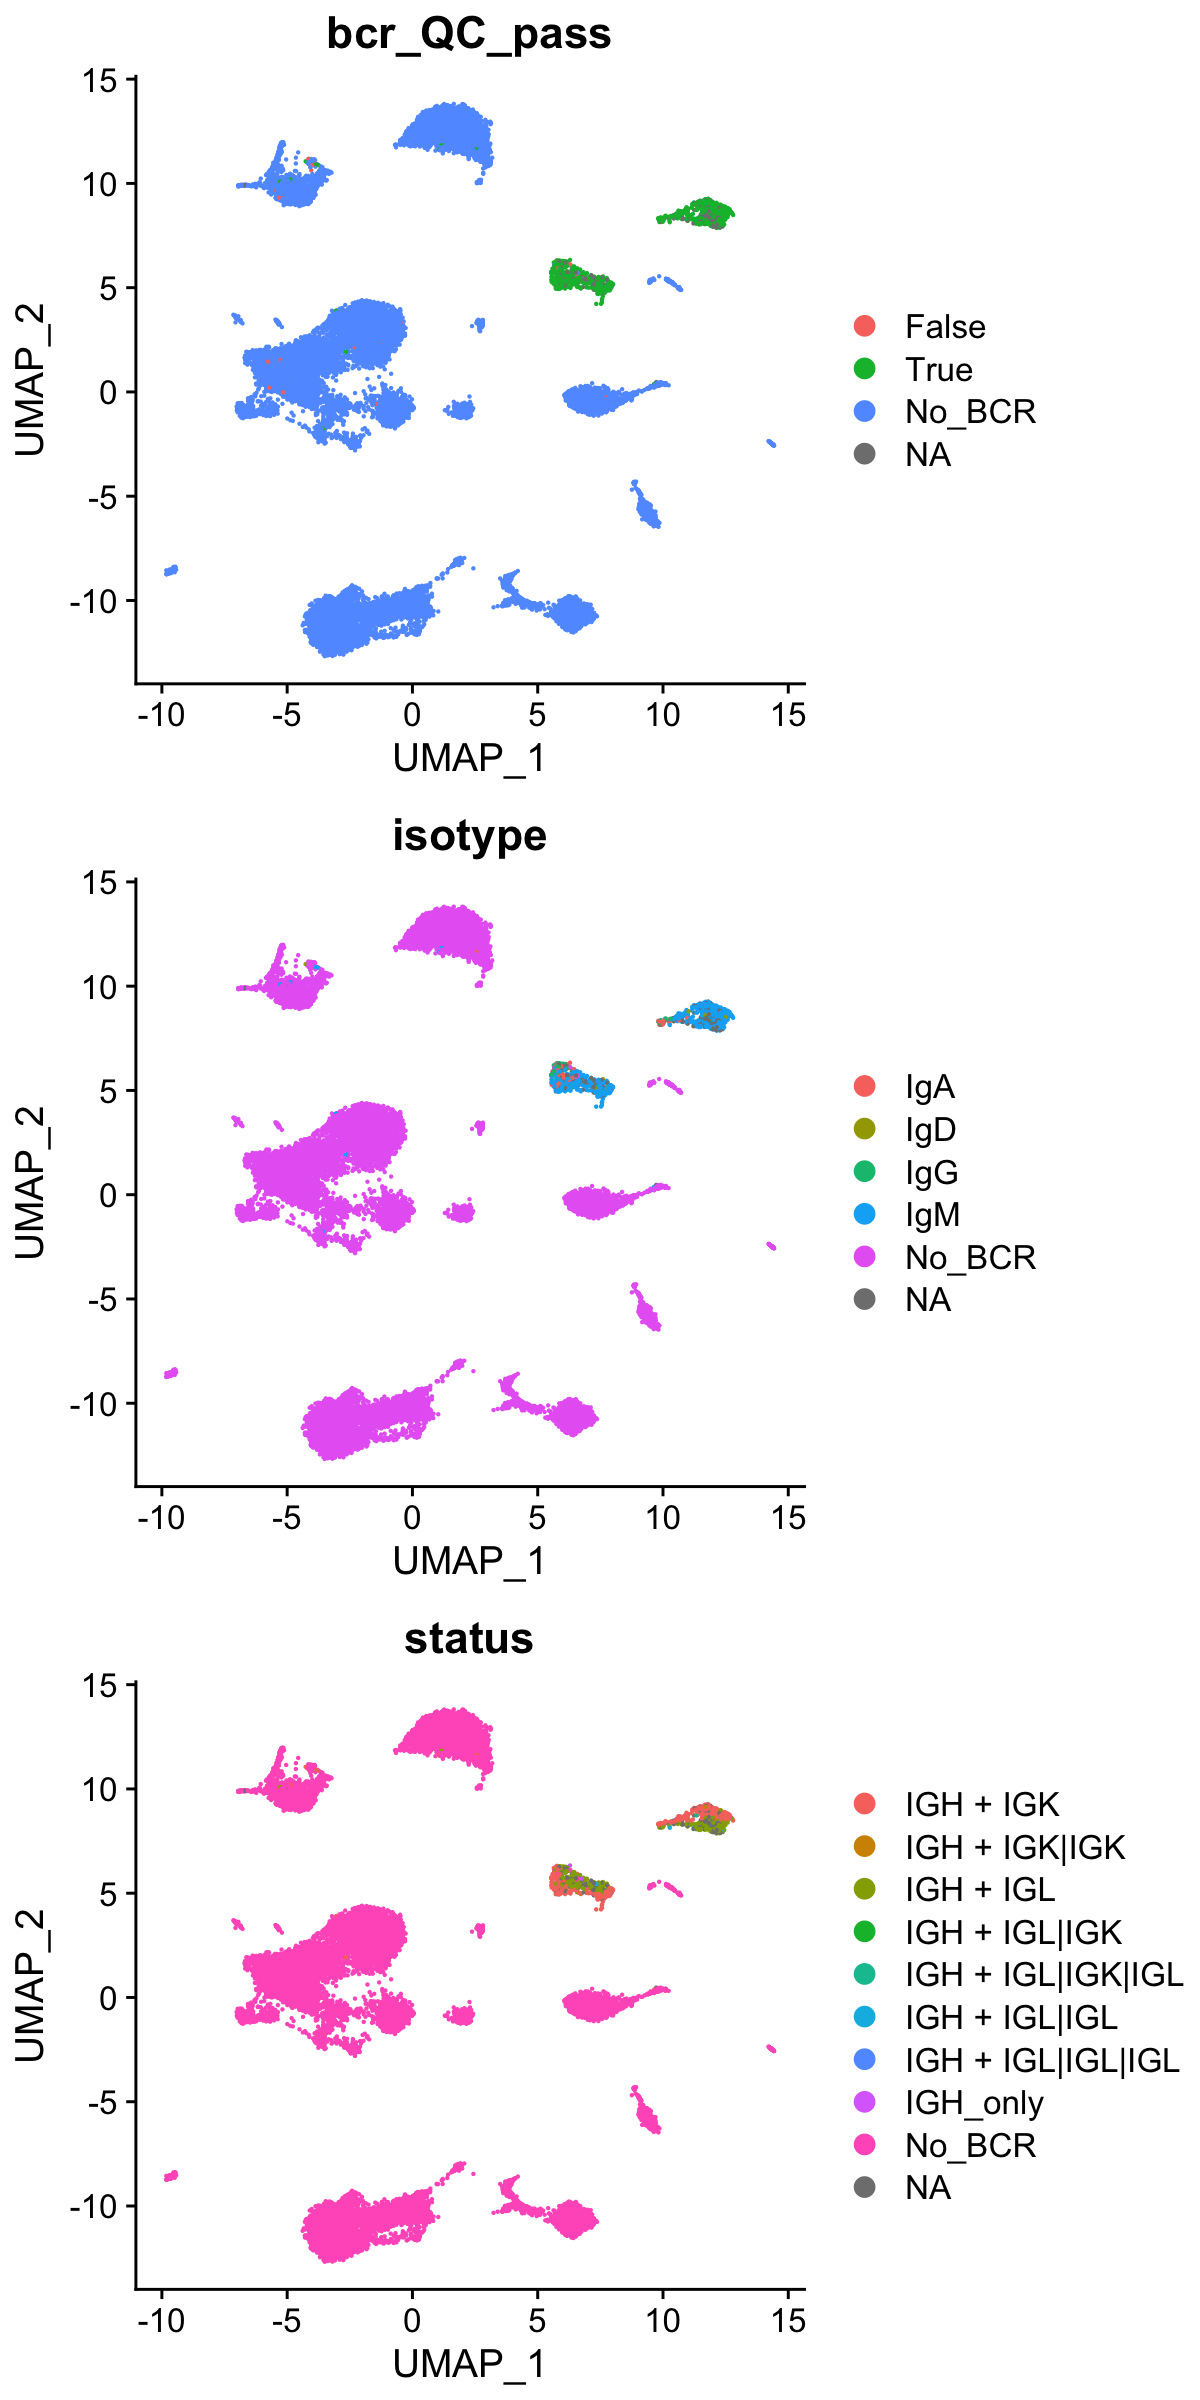

In [9]:
options(repr.plot.width = 6, repr.plot.height = 12, repr.plot.res = 200)
DimPlot(merged, group.by = c('bcr_QC_pass', 'isotype', 'status'), ncol = 1)

If you want to visualise the BCR network, you will have to subset to cells that contain BCR.

In [10]:
merged_bcr = subset(merged, subset = bcr_QC_pass == 'True')
merged_bcr

An object of class Seurat 
38224 features across 971 samples within 1 assay 
Active assay: RNA (38224 features, 2000 variable features)
 2 dimensional reductions calculated: pca, umap

## Plotting BCR network

In [11]:
X_bcr = adata$obsm['X_bcr']
X_bcr <- apply(X_bcr, 2, function(x) gsub('NaN', NA, x)) # convert python NAs to R NAs
X_bcr <- apply(X_bcr, 2, function(x) as.numeric(x)) # Make sure they are actually numbers
X_bcr <- as.matrix(X_bcr)
row.names(X_bcr) <- row.names(adata$obs) # will not work if the anndata .obs slot is malformed. the row.names for adata$obs and row.names(merged_bcr@meta.data) should be identical anyway, so just replace with row.names(merged_bcr@meta.data)
X_bcr <- X_bcr[!is.na(X_bcr[,1]), ]
colnames(X_bcr) <- c('BCR_1', 'BCR_2')

In [12]:
merged_bcr[["BCR"]] <- CreateDimReducObject(embeddings = X_bcr, key = "BCR_", assay = DefaultAssay(merged_bcr))

In [13]:
merged_bcr

An object of class Seurat 
38224 features across 971 samples within 1 assay 
Active assay: RNA (38224 features, 2000 variable features)
 3 dimensional reductions calculated: pca, umap, BCR

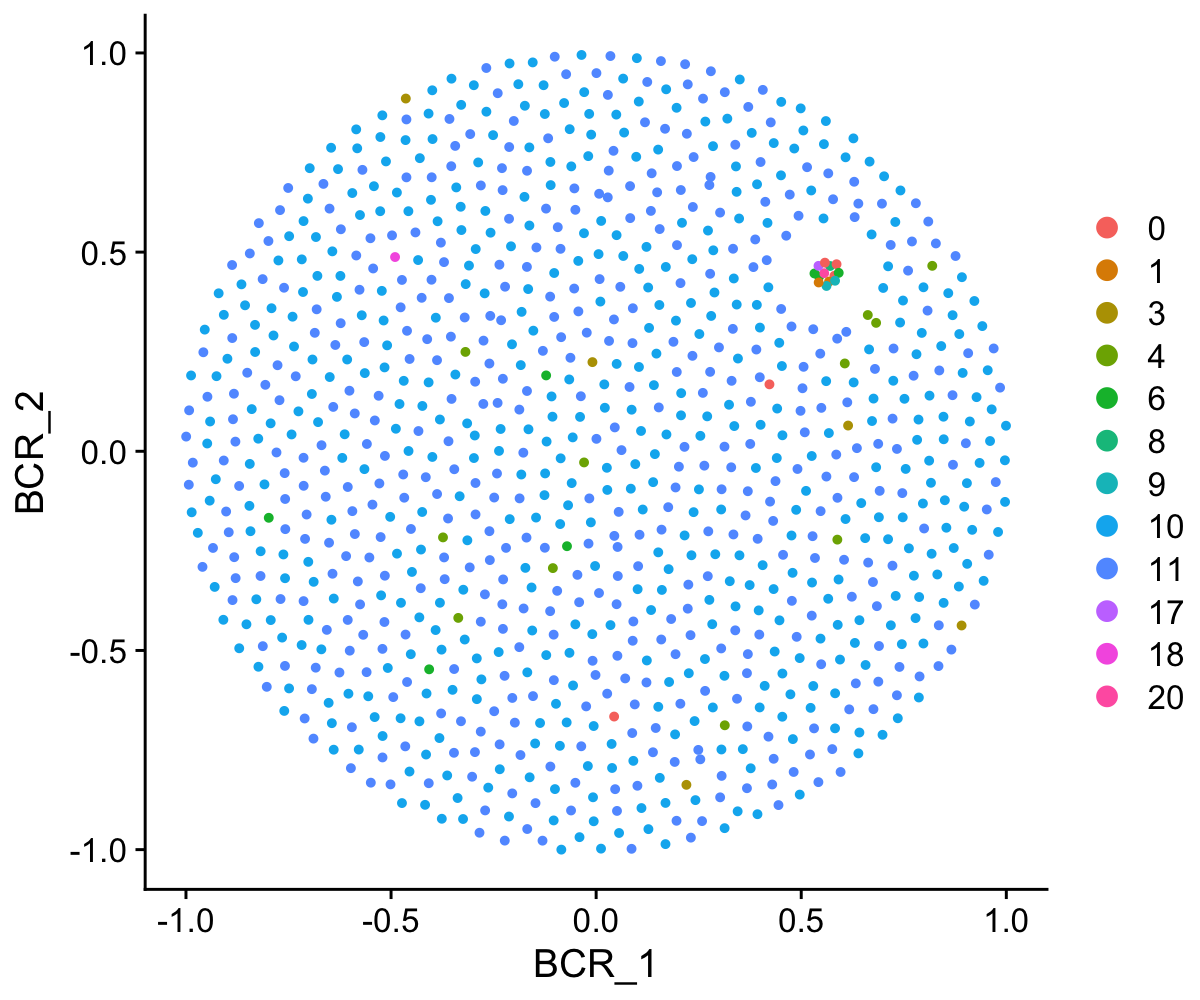

In [14]:
options(repr.plot.width = 6, repr.plot.height = 5, repr.plot.res = 200)
DimPlot(merged_bcr, reduction = 'BCR')

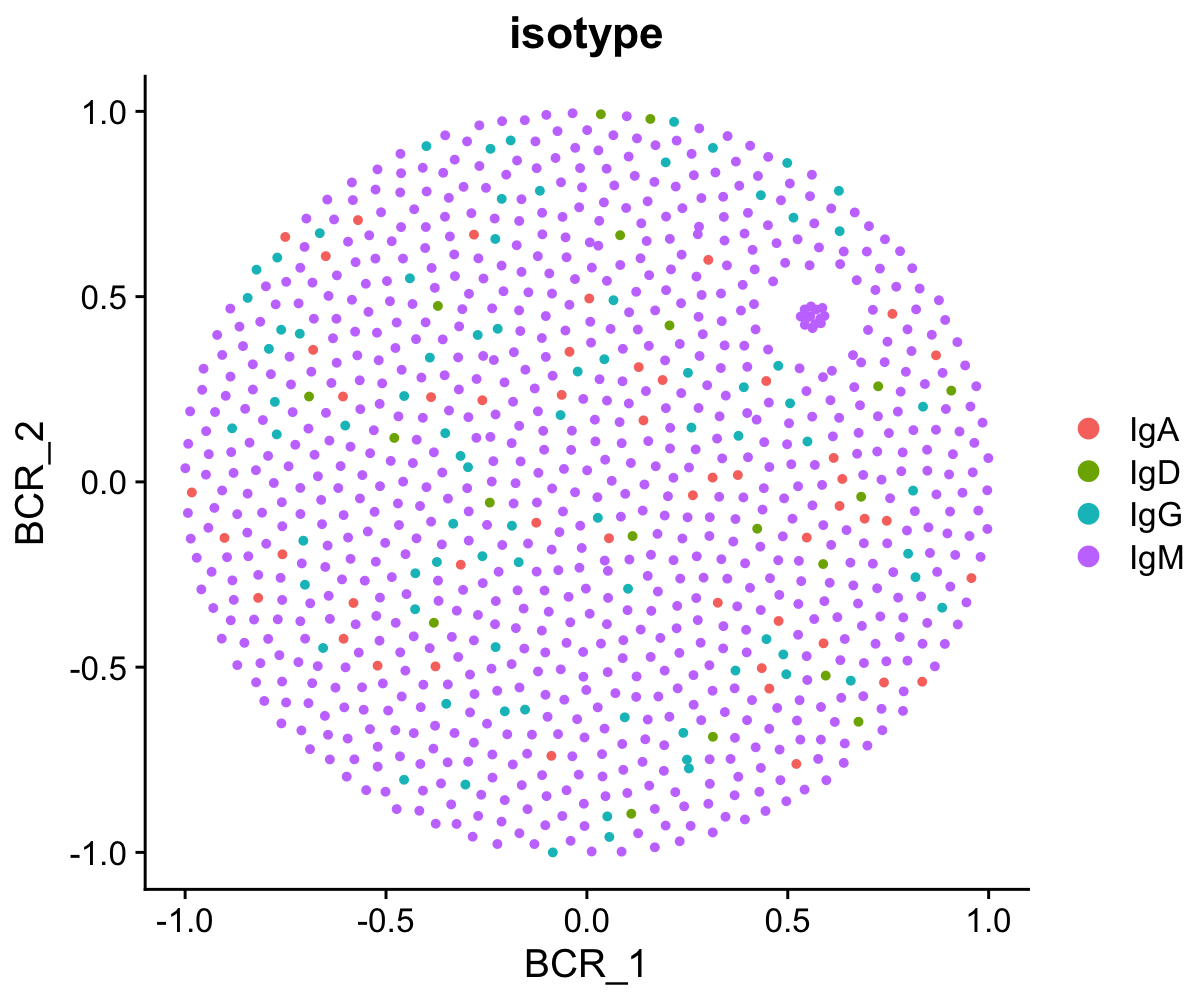

In [15]:
DimPlot(merged_bcr, reduction = 'BCR', group.by = 'isotype')

This concludes a quick primer on how to use `dandelion` from R. It may be a bit buggy from time to time due to how reticulate works but hopefully it will be overall alright.

The rest of the functions could be potentially run from R (just be changing `.` to `$` for example), but I haven't tested it. Might be easier to run it through python, or maybe with the new RStudio 4?

In [16]:
sessionInfo()

R version 4.0.2 (2020-06-22)
Platform: x86_64-apple-darwin17.0 (64-bit)
Running under: macOS Mojave 10.14.6

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.0/Resources/lib/libRblas.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/4.0/Resources/lib/libRlapack.dylib

locale:
[1] en_GB.UTF-8/en_GB.UTF-8/en_GB.UTF-8/C/en_GB.UTF-8/en_GB.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] Seurat_3.9.9.9010 reticulate_1.18  

loaded via a namespace (and not attached):
  [1] nlme_3.1-148          matrixStats_0.57.0    RcppAnnoy_0.0.17     
  [4] RColorBrewer_1.1-2    httr_1.4.2            repr_1.1.0           
  [7] sctransform_0.3.1     tools_4.0.2           R6_2.5.0             
 [10] irlba_2.3.3           rpart_4.1-15          KernSmooth_2.23-17   
 [13] uwot_0.1.9            mgcv_1.8-31           lazyeval_0.2.2       
 [16] colorspace_2.0-0      tidyselect_1.1.0      gridEx